In [1]:
import numpy as np
from scipy import linalg
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import clear_output
plt.rcParams['text.usetex'] = True
from copy import deepcopy as copy

In [2]:
class statevector(np.ndarray): #extends the np.ndarray class to add functionalities like normalize, evolve under hamiltonian and also obtain density matrix
    def __new__(cls, input_array):
        obj = np.asarray(input_array, dtype=np.complex64).view(cls)
        return obj

    def H(self):
        return self.conj().T
    
    def get_norm(self):
        normVal = self.H()@self
        return normVal[0][0].real
    
    def normalize(self):
        if self.get_norm() != 0:
            self[:] = self/(self.get_norm()**0.5)
        return self
    
    def evolve(self, Hamiltonian, time, method='exact', dt=0):
        if method not in ['exact', 'trotter']:
            raise AttributeError(f"The specified method '{method}' does not exist.")
        
        if method == 'exact':
            evolvedstate = linalg.expm(-1j*Hamiltonian*time)@self
        else:
            size, __ = Hamiltonian.shape
            trotter_term = (operator(np.identity(size)) - 1j*Hamiltonian*dt)
            N = int(time/dt)
            evolvedstate = self
            for __ in range(N):
                evolvedstate = trotter_term@evolvedstate
            evolvedstate.view(statevector).normalize()
        
        self[:] = evolvedstate
        return self
    
    def get_rho(self):
        state = np.copy(self).view(statevector)
        state.normalize()
        rho = state@state.H()
        return rho.view(operator)


class operator(np.ndarray): #extends the np.ndarray class to add functionalities like expectation value of the operator for a given statevector
    def __new__(cls, input_array):
        obj = np.asarray(input_array, dtype=np.complex64).view(cls)
        return obj

    def H(self):
        return self.conj().T
    
    def expectation_value(self, state:statevector):
        state.normalize()
        exp_val =  state.H()@self@state
        return exp_val[0][0].real

def natural_range(*args): #used to prevent confusions in coversion from natural index used in Hamiltonian and other Operators to python index
    '''
    natural_range(start, end) yields (i_p, i_n) where i_p is the programming index starting from start-1 to end-1 and i_n is the natural index starting from start to end. 
    'start' will default to 1 if natural_range is called with single arg.
    '''
    try:
        start = args[-2] - 1
    except:
        start = 0
    
    end = args[-1]
    
    for i in range(start, end):
        yield (i, i+1)


In [3]:
# basic defs
sx = operator([[0, 1],[1, 0]])
sy = operator([[0, -1j],[1j, 0]])
sz = operator([[1, 0],[0, -1]])
sp = (sx + 1j*sy)/2
sm = (sx - 1j*sy)/2
id_2 = np.eye(2, dtype=np.complex64).view(operator)

In [4]:
def get_pauli(
        N:int,
        ) -> tuple[list[operator]]:
    sigma_p = []
    sigma_m = []
    sigma_z = []

    sp_listform = [[sp if k==l else id_2 for k in range(N)] for l in range(N)]
    sm_listform = [[sm if k==l else id_2 for k in range(N)] for l in range(N)]
    sz_listform = [[sz if k==l else id_2 for k in range(N)] for l in range(N)]

    for i in range(N):
        temp = sp_listform[i][0]
        for pauli in sp_listform[i][1:]:
            temp = np.kron(temp, pauli)
        sigma_p.append(temp)

        temp = sm_listform[i][0]
        for pauli in sm_listform[i][1:]:
            temp = np.kron(temp, pauli)
        sigma_m.append(temp)

        temp = sz_listform[i][0]
        for pauli in sz_listform[i][1:]:
            temp = np.kron(temp, pauli)
        sigma_z.append(temp)

    id_N = operator(np.eye(2**N))

    return sigma_p, sigma_m, sigma_z, id_N

In [5]:
def get_hamiltonian(
        N:int, 
        coeffs: tuple[float]
        )->operator:
    '''
    takes N: numer of lattice sites and coeffs: (M, J, W) and returns the Hamiltonian for the system
    '''
    (sigma_p, sigma_m, sigma_z, id_N) = get_pauli(N)
    (M, J, W) = coeffs

    # the natural_range method returns the tuple (python index, natural index), which I have denoted by adding _p and _n to the indices

    # H_Z

    hamiltonian_z1 = operator(np.zeros_like(id_N))

    for (n_p, n_n) in natural_range(1, N):
        hamiltonian_z1 += (-1)**n_n*sigma_z[n_p]
    hamiltonian_z1 *= (M/(2*W))

    hamiltonian_z2 = operator(np.zeros_like(id_N))
    
    for (n_p, n_n) in natural_range(1, N-1):
        coeff = 1 - (-1)**n_n
        if coeff!=0:
            term = operator(np.zeros_like(id_N))
            for (l_p, l_n) in natural_range(1, n_n):
                term += sigma_z[l_p]
            hamiltonian_z2 += coeff*term

    hamiltonian_z2 *= (-J)/(4*W)

    hamiltonian_z = hamiltonian_z1 + hamiltonian_z2

    # H_{\pm}

    hamiltonian_pm = operator(np.zeros_like(id_N))

    for (n_p, n_n) in natural_range(1, N-1):
        term = sigma_p[n_p]@sigma_m[n_p + 1]
        hamiltonian_pm += term + term.H()
    
    # H_{ZZ}
    hamiltonian_zz = operator(np.zeros_like(id_N))

    for (n_p, n_n) in natural_range(1, N-2):
        for (l_p, l_n) in natural_range(n_n+1, N-1):
            hamiltonian_zz += (N - l_n)*sigma_z[n_p]@sigma_z[l_p]
    hamiltonian_zz *=  (J/(2*W))

    hamiltonian = hamiltonian_z + hamiltonian_pm + hamiltonian_zz

    return hamiltonian

In [6]:
def get_particle_density(N:int) -> operator:
    __, __, sigma_z, id_N = get_pauli(N)

    particle_density = operator(np.zeros_like(id_N))

    for (n_p, n_n) in natural_range(1, N):
        particle_density += ((-1)**n_n)*sigma_z[n_p] + id_N

    particle_density /= (2*N)

    return particle_density

In [7]:
def half_chain_entanglement_entropy(state:statevector):
    rho = state.get_rho()
    N, _ = rho.shape
    N = np.log2(N)
    if N%2!=0:
        raise ValueError("Number of lattice sites should be even")
    half = 2**int(N/2)

    id_half = np.eye(half)

    rho_A = operator(np.zeros_like(id_half))

    for i in range(half):
        basis = statevector([1 if j==i else 0 for j in range(half)])
        left_mat = np.kron(basis, id_half)
        rho_A += left_mat @ rho @ left_mat.T

    entropy = -np.trace(rho_A @ linalg.logm(rho_A))

    return entropy.real

In [8]:
def get_electric_field(N):

    __, __, sigma_z, id_N = get_pauli(N)

    fields = [operator(np.zeros_like(id_N)) for _ in range(N-1)]

    for (n_p, n_n) in natural_range(1, N-1):
        for (l_p, l_n) in natural_range(1, n_n):
            fields[n_p] += (sigma_z[l_p] + ((-1)**l_n)*id_N)/2

    return fields

In [9]:
def complex_random(m:int, n:int=1, range:tuple[float]=(-1,1)):
    '''
    Generates a random complex matrix of size m x n, with random entries in the specified range
    '''
    low = range[0]
    high = range[1]
    low_mat = low*( np.ones(shape=(m,n)) + 1j*np.ones(shape=(m,n)) )
    diff = high - low
    rand_01 = np.random.random((m,n)) + 1j*np.random.random((m,n))
    
    return low_mat + diff*rand_01

In [10]:
class MPS:
    def __init__(self, 
                N:int, # Number of sites
                d:int, # Dimension of the Local Hilbert space
                D:int, # Bond dimension
                hamiltonian:operator #h Hamiltonian
    ):
        super().__init__()
        self.N = N
        self.d = d
        self.D = D
        self.hamiltonian = hamiltonian

        prod_state = []
        for i in range(N):
            prod_state.append([])
            for j in range(d):
                prod_state[-1].append(complex_random(D,D))
        
        self.state = prod_state


    def normalize(self, state=None):
        if state is not None:
            prod_state = state
        else:
            prod_state = self.state
        
        N = self.N
        norm = self.to_statevector(state=prod_state).get_norm()**(1/N)
        for site in prod_state:
            for basis in site:
                basis *= 1/norm
        
        if state is not None:
            return prod_state
        else:
            self.state[:] = copy(prod_state)

    def generate_lattice_basis(self):
            bit_count = self.N
            basis = []
            def genbin(n, bs=''):
                if len(bs) == n:
                    basis.append(list(map(int, list(bs))))
                else:
                    genbin(n, bs + '0')
                    genbin(n, bs + '1')


            genbin(bit_count)
            return basis

    def to_statevector(self, state=None):
        if state is not None:
            prod_state = state
        else:
            prod_state = self.state
        
        basis_states = self.generate_lattice_basis()

        state_vec = np.zeros(shape=(2**self.N, 1), dtype=np.complex64)

        for index, basis in enumerate(basis_states):
            matrix = np.ones(shape=(self.D, self.D))
            for i in range(self.N):
                matrix = matrix @ prod_state[i][basis[i]]
            state_vec[index] = np.trace(matrix)

        return statevector(state_vec)
    
    def derivative_statevector(self, state, site, basis):
        prod_state = state

        basis_states = self.generate_lattice_basis()

        state_vec = np.zeros(shape=(2**self.N, 1), dtype=np.complex64)

        for index, basis_state in enumerate(basis_states):
            if basis_state[site] == basis:
                matrix = np.ones(shape=(self.D, self.D))
                for i in range(self.N):
                    matrix = matrix @ prod_state[i][basis_state[i]]
                state_vec[index] = np.trace(matrix)
                
        return statevector(state_vec)


    def get_gradients(self):
        state = self.state
        gradients = [[np.zeros_like(state[0][0]) for d in range(self.d)] for N in range(self.N)]

        max_grad = 0

        for site in range(self.N):
            for basis in range(self.d):
                for index in np.ndindex((self.D, self.D)):
                    for imaginary_part in [False, True]:
                        d_state = copy(state)
                        d_state[site][basis] = np.zeros_like(d_state[site][basis], dtype=np.complex64)
                        d_state[site][basis][index] = 1*(1j if imaginary_part else 1)

                        state_vec = self.to_statevector(state=state)
                        d_state_vec = self.derivative_statevector(state=d_state, site=site, basis=basis)

                        grad = ( (state_vec.H() @ state_vec)[0][0] * ( state_vec.H() @ self.hamiltonian @ d_state_vec   +   d_state_vec.H() @ self.hamiltonian @ state_vec )[0][0] - 
                                (d_state_vec.H() @ state_vec + state_vec.H() @ d_state_vec)[0][0] * (state_vec.H() @ self.hamiltonian @ state_vec)[0][0] )/((state_vec.H() @ state_vec)[0][0]**2)
                        gradients[site][basis][index] += grad*(1j if imaginary_part else 1)
                        if abs(grad) > max_grad:
                            max_grad = abs(grad)

        return gradients, max_grad


    def apply_gradient(self, learning_rate:float=1e-2):
        state = copy(self.state)
        gradients, max_grad = self.get_gradients()
        state[:] = [[mat - learning_rate*grad_mat for (mat, grad_mat) in zip(mat_at_site, grad_at_site)] for (mat_at_site, grad_at_site) in zip(state, gradients)]
        self.state[:] = state
        return max_grad

In [ ]:
N = 8
d = 2
D = 2
monte_carlo_steps = 5000
learning_rate = 1e-1
tolerance = 1e-3
masses = [0,0.5,1]
states = []
energies = []

for m in masses:
    print(f"Bare mass: {m}")
    hamiltonian = get_hamiltonian(N=N, coeffs=(m, 1, 1))
    state = MPS(N=N, d=d, D=D, hamiltonian=hamiltonian)
    for step in tqdm(range(monte_carlo_steps)):
        grad = state.apply_gradient(learning_rate=learning_rate)
        energy = hamiltonian.expectation_value(state.to_statevector())
        if step%100 == 0: 
            print(f'Step: {step}, Energy: {energy}, Max-Grad: {grad}')
        if grad < tolerance:
            break
    clear_output()
    states.append(state.to_statevector())
    energies.append(energy)



In [12]:
# import pickle

# energy_pickle_file = open('dumps/energies_for_timeevolution', 'wb')
# pickle.dump(energies, energy_pickle_file)
# energy_pickle_file.close()

# states_pickle_file = open('dumps/states_for_timeevolution', 'wb')
# pickle.dump(states, states_pickle_file)
# states_pickle_file.close()

In [13]:
def run_simulation(
        N:int,
        coeffs: tuple[float],
        state: statevector,
        time: float, 
        slices: int, 
        method: str = 'exact',
        dt = 0,
        calculate_particle_density: bool = False,
        calculate_entropy: bool = False,
        calculate_energy: bool = False,
        calculate_electric_field: bool = False
        ) -> tuple[list]:
    
    hamiltonian = get_hamiltonian(N, coeffs)
    particle_density_observable = get_particle_density(N)
    electric_fields_observable = get_electric_field(N)

    particle_densities = []
    entropies = []
    energies = []
    electric_fields = []

    time_linspace = np.linspace(0, time, slices)
    delta_t = time_linspace[1] - time_linspace[0]

    for t in tqdm(time_linspace):
        state.evolve(hamiltonian, delta_t, method=method, dt=dt)
        if calculate_particle_density:
            particle_densities.append(particle_density_observable.expectation_value(state))
        if calculate_entropy:
            entropies.append(half_chain_entanglement_entropy(state))
        if calculate_energy:
            energies.append(hamiltonian.expectation_value(state))
        if calculate_electric_field:
            electric_fields.append([field.expectation_value(state) for field in electric_fields_observable])

    return particle_densities, entropies, energies, electric_fields

In [20]:
time = 3
slices = 31

time_linspace = np.linspace(0, time, slices)
dt = (time_linspace[1] - time_linspace[0])/500

particle_densities_l = [[],[]]
entropies_l = [[],[]]
labels = []

for m_index in range(len(masses)):
    print(f'Running for (M, J, W) = ({masses[m_index]}, 1, 1) exact method')
    particle_densities_e, entropies_e, energies, __ = run_simulation(N=N, state=copy(states[m_index]), coeffs=(masses[m_index], 1, 1), time=time, slices=slices, calculate_particle_density=True, calculate_entropy=True, calculate_energy=True)
    clear_output()

    print(f'Running for (M, J, W) = ({masses[m_index]}, 1, 1), trotter method')
    particle_densities_t, entropies_t, __, __ = run_simulation(N=N,  state=copy(states[m_index]), coeffs=(masses[m_index], 1, 1), time=time, slices=slices, method='trotter', dt=dt, calculate_particle_density=True, calculate_entropy=True, calculate_energy=True)
    clear_output()

    particle_densities_l[0].append(particle_densities_e)
    entropies_l[0].append(entropies_e)
    
    particle_densities_l[1].append(particle_densities_t)
    entropies_l[1].append(entropies_t)
    labels.append(masses[m_index]/1)

clear_output()

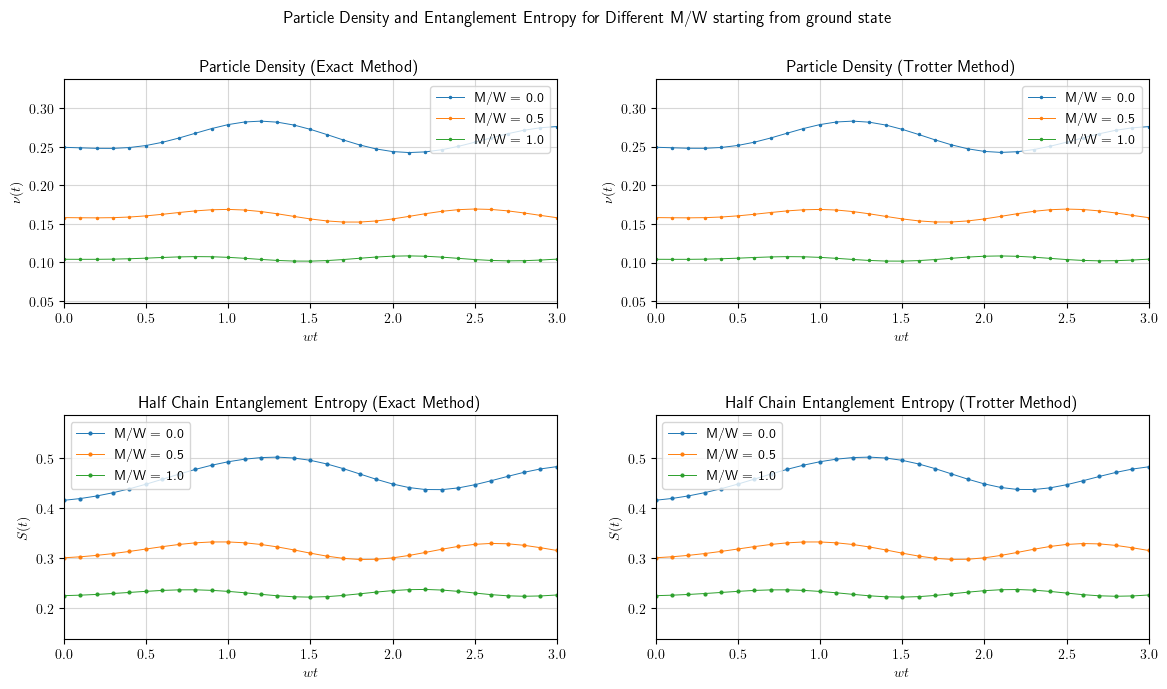

In [21]:

fig, ax = plt.subplots(nrows=2, ncols=2, figsize = (14,14))
fig.suptitle("Particle Density and Entanglement Entropy for Different M/W starting from ground state", y=1.55)

for (pd, ent, lab) in zip(particle_densities_l[0], entropies_l[0], labels):  
    ax[0,0].plot(time_linspace, pd, '.-', label=f'M/W = {lab}', linewidth=0.7, markersize=3)
    ax[1,0].plot(time_linspace, ent, '.-', label=f'M/W = {lab}', linewidth=0.7, markersize=4)

for (pd, ent, lab) in zip(particle_densities_l[1], entropies_l[1], labels):  
    ax[0,1].plot(time_linspace, pd, '.-', label=f'M/W = {lab}', linewidth=0.7, markersize=3)
    ax[1,1].plot(time_linspace, ent, '.-', label=f'M/W = {lab}', linewidth=0.7, markersize=4)

ax[0,0].set_title("Particle Density (Exact Method)")
ax[0,1].set_title("Particle Density (Trotter Method)")
ax[1,0].set_title("Half Chain Entanglement Entropy (Exact Method)")
ax[1,1].set_title("Half Chain Entanglement Entropy (Trotter Method)")

legends = [[axis.legend(loc="best") for axis in axisrow] for axisrow in ax]
margins = [[axis.margins(x=0, y=0.3) for axis in axisrow] for axisrow in ax]
xlabels = [[axis.set_xlabel(r"$wt$") for axis in axisrow] for axisrow in ax]
ylabels = [[axis.set_ylabel(r"$\nu(t)$") for axis in ax[0]], [axis.set_ylabel(r"$S(t)$") for axis in ax[1]]]
grids = [[axis.grid(True, alpha=0.5) for axis in axisrow] for axisrow in ax]

plt.subplots_adjust(bottom=1.1, top=1.5, hspace=0.5)
plt.show()

In [22]:
coeffs = (1,1,1) 
time = 10
slices = 101

time_linspace = np.linspace(0, time, slices)
dt = (time_linspace[1] - time_linspace[0])/500

__, __, __, electric_fields_e = run_simulation(N=N, state=copy(states[2]), coeffs=(1,1,1), time=time, slices=slices, calculate_electric_field=True)
clear_output()
__, __, __, electric_fields_t = run_simulation(N=N, state=copy(states[2]), coeffs=(1,1,1), time=time, slices=slices, method='trotter', dt=dt, calculate_electric_field=True)
clear_output()


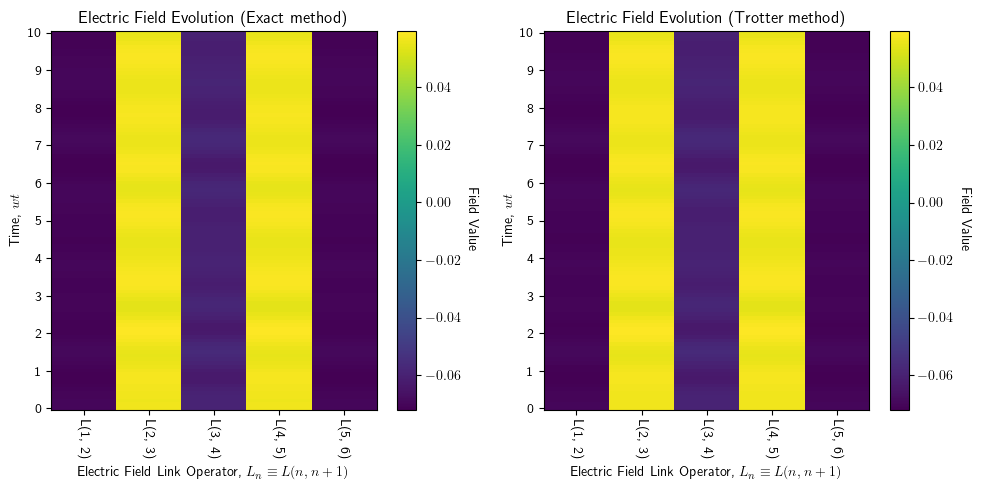

In [23]:
fields_e = np.array(electric_fields_e)
fields_t = np.array(electric_fields_t)
fig, ax = plt.subplots(nrows = 1, ncols =2, figsize=(10, 5))

im_e = ax[0].imshow(fields_e, cmap='viridis', aspect='auto', origin='lower')
im_t = ax[1].imshow(fields_t, cmap='viridis', aspect='auto', origin='lower')

yticks = [axis.set_yticks(range(slices)[0::10], range(11)) for axis in ax]
xticks = [axis.set_xticks(range(N-1), [f'L({i}, {i+1})' for i in range(1, N)], rotation=-90) for axis in ax]
cbar_e = ax[0].figure.colorbar(im_e, ax=ax[0])
cbar_e.ax.set_ylabel('Field Value', rotation=-90, va="bottom")
cbar_t = ax[1].figure.colorbar(im_t, ax=ax[1])
cbar_t.ax.set_ylabel('Field Value', rotation=-90, va="bottom")

xlabels = [axis.set_xlabel(r"Electric Field Link Operator, $L_{n} \equiv L(n, n+1)$") for axis in ax]
ylabels = [axis.set_ylabel(r"Time, $wt$") for axis in ax]
ax[0].set_title("Electric Field Evolution (Exact method)")
ax[1].set_title("Electric Field Evolution (Trotter method)")

plt.tight_layout()
plt.show()
